# Assignment 3 

Project Name: COSC102 - Assignment 3 – Machine Learning Portfolio: Comparing the Performance of Machine Learning Approaches for Activity Classification <br>
Authors: - <br>
Email: - <br>
Date: - 12/08/24<br>

BLOCK OF INFO EXPLAINING THE PROJECT AND WHAT WE WILL BE DOING.

In [614]:
# Import statements

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, recall_score, precision_score
from matplotlib.colors import ListedColormap
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import VotingClassifier

## Load data

We will begin by loading up our data sets and running through the beginning checklist of any data science project. This includes<br>
inspecting our data sets, checking for missing values and fixing any preliminary probelms we might see before moving onto the steps.

In [353]:
# function to load csv files as pandas dataframe

def load_data(csv, header, col_names):
    """
    Takes a csv's file path in the form of a string and 
    returns a pandas dataframe of the csv, if the dataset
    has no column names, it will append a passed in list
    of column names, otherwise it will leave the dataset 
    as is.
    Params:
    String - csv, string of the file path for a given csv
    header - Paramater deciding if the first row of the csv 
    are the column names or not, pass "infer" if you data
    set has column names and "None" if it doesn't
    names - A list of column names to assign to the dataset
    only if the headers parameter is "None", pass None for
    this parameter if your dataset already has column names.
    Returns:
    Pandas dataframe of our csv file
    """
    return pd.read_csv(csv, header=header, names=col_names)    

In [354]:
# File paths for our csv data sets
IMU_DATA = "./a3_imu_data.csv"
ACTIVITY_DATA = "./a3_activity_annotations.csv"

Looking at the raw csv files outside of the project, we noticed that the imu data set has no column names, we are going to need<br>
to assign the data set column names so that it is easier/possible to work with. The names chosen were taken from the assignments <br>
task sheet. The activity data already had column names assigned and accurate, so no work was neccersary on them.

In [355]:
# Initialing our datasets as pandas dataframes and assigning column names

# List of column namesColumn 
imu_col_names = ["timestamp", "x_axis_accel", "y_axis_accel", "z_axis_accel", "x_axis_gyro", "y_axis_gyro", "z_axis_gyro"]

# Loading our csv files, the imu set has no column names so we are passing in a list of names to add
# The activity dataset comes with names so we leave it as it is and pass in "None" for column names
imu_data_raw = load_data(IMU_DATA, None, imu_col_names)
activity_data_raw = load_data(ACTIVITY_DATA, "infer", None)

That should do the job, now let's look and see what our datasets look like, check for missing values, and plot a basic visualization<br> of the data sets.

In [356]:
# Function to check for any null values

def check_for_null(dataset, name):
    """
    Takes a pandas dataframe and the name of the dataframe as a string and
    checks if there are any missing values in all columns, prints out the 
    results
    Params:
    dataset - A pandas dataframe 
    name - A string for the name of your dataframe
    """
    print(f"{name}'s NULL values \n")
    for col in dataset.columns:
        print(f"{dataset[col].name} has {dataset[col].isnull().sum()} null values")

In [390]:
# Function to display a basic plot of our data

def plot_dataframe(X, y, title):
    """
    Takes an X and y from a pandas dataseries as well as the title in the form of a string. 
    The X value should be a single column of values from a pandas dataframe, the y values
    can contain as many columns as you like.
    Params:
    X - Pandas series containing the x value for our plot
    y - Pandas series containing the y value(s) for our plot
    title - String containing the desired title for our plot
    """
    # Create a figure
    fig, ax = plt.subplots(figsize=(18,10))

    # for every column in the y set, get the column name and append it to a list of labels
    
    labels=[i for i in y.columns]

    # Plot the data and add basic quality of life features
    plt.plot(X, y, label= labels)
    ax.set_xlabel(X.name, fontsize=18)
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_ylabel("Values", fontsize=18)
    ax.set_title(title, fontsize=22)
    plt.grid()
    plt.legend()

## Visualize the datasets and inspect for alignment errors

### IMU Dataset Inspection

In [358]:
# Check for null values
check_for_null(imu_data_raw, "IMU DATA")


IMU DATA's NULL values 

timestamp has 0 null values
x_axis_accel has 0 null values
y_axis_accel has 0 null values
z_axis_accel has 0 null values
x_axis_gyro has 0 null values
y_axis_gyro has 0 null values
z_axis_gyro has 0 null values


In [359]:
# Get basic information
imu_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71242 entries, 0 to 71241
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   timestamp     71242 non-null  int64
 1   x_axis_accel  71242 non-null  int64
 2   y_axis_accel  71242 non-null  int64
 3   z_axis_accel  71242 non-null  int64
 4   x_axis_gyro   71242 non-null  int64
 5   y_axis_gyro   71242 non-null  int64
 6   z_axis_gyro   71242 non-null  int64
dtypes: int64(7)
memory usage: 3.8 MB


In [360]:
# Visualise the dataframe
imu_data_raw.head()

,timestamp,x_axis_accel,y_axis_accel,z_axis_accel,x_axis_gyro,y_axis_gyro,z_axis_gyro
0,1598240213,-2402,1710,-380,-1413,-362,223
1,1598240213,-1880,1688,-420,-1469,-597,-23
2,1598240213,-1558,1568,-606,-1535,-872,-195
3,1598240213,-1154,1732,-654,-1293,-976,-335
4,1598240213,-452,2084,-754,-719,-940,-214


From above we can see that that our timestamps are calculated as unix time stamps, we might want to convert these to seconds before we plot <br>
the series to avoid some unpretty looking axis values. This will also come in handy later on in this project when aligning the two dataset's. <br>


In [361]:
# Creating a function specifically to convert unix time stamps to seconds

def convert_time_series(data_series):
    """
    Converts a series consisting of unix timestamps to seconds and returns the series
    Params:
    data_series - a pandas dataseries of unix timestamps
    Returns:
    A time series in seconds
    """
    # Assign the timestamp to a variable
    time = data_series

    # Create a starting time outside of our loop so that it doesn't change value
    # as we iterate through each value of the series
    start_time = time[0]
    
    # Iterate through every value of the timestamp column
    for row in time:
        # Get the time in the timstamp column, minus the first value, and plus 1,
        # this will essentially count seconds from the start of the dataseries
        calc_seconds = row - start_time + 1
        # Take the value calculated above and replace it in our time column, this
        # will remove the unix timestamp from the column and replace it with the
        # difference in seconds since the start of the dataseries
        time = time.replace(to_replace=row, value=calc_seconds)
    
    # Add the new time series to our dataframe
    return time

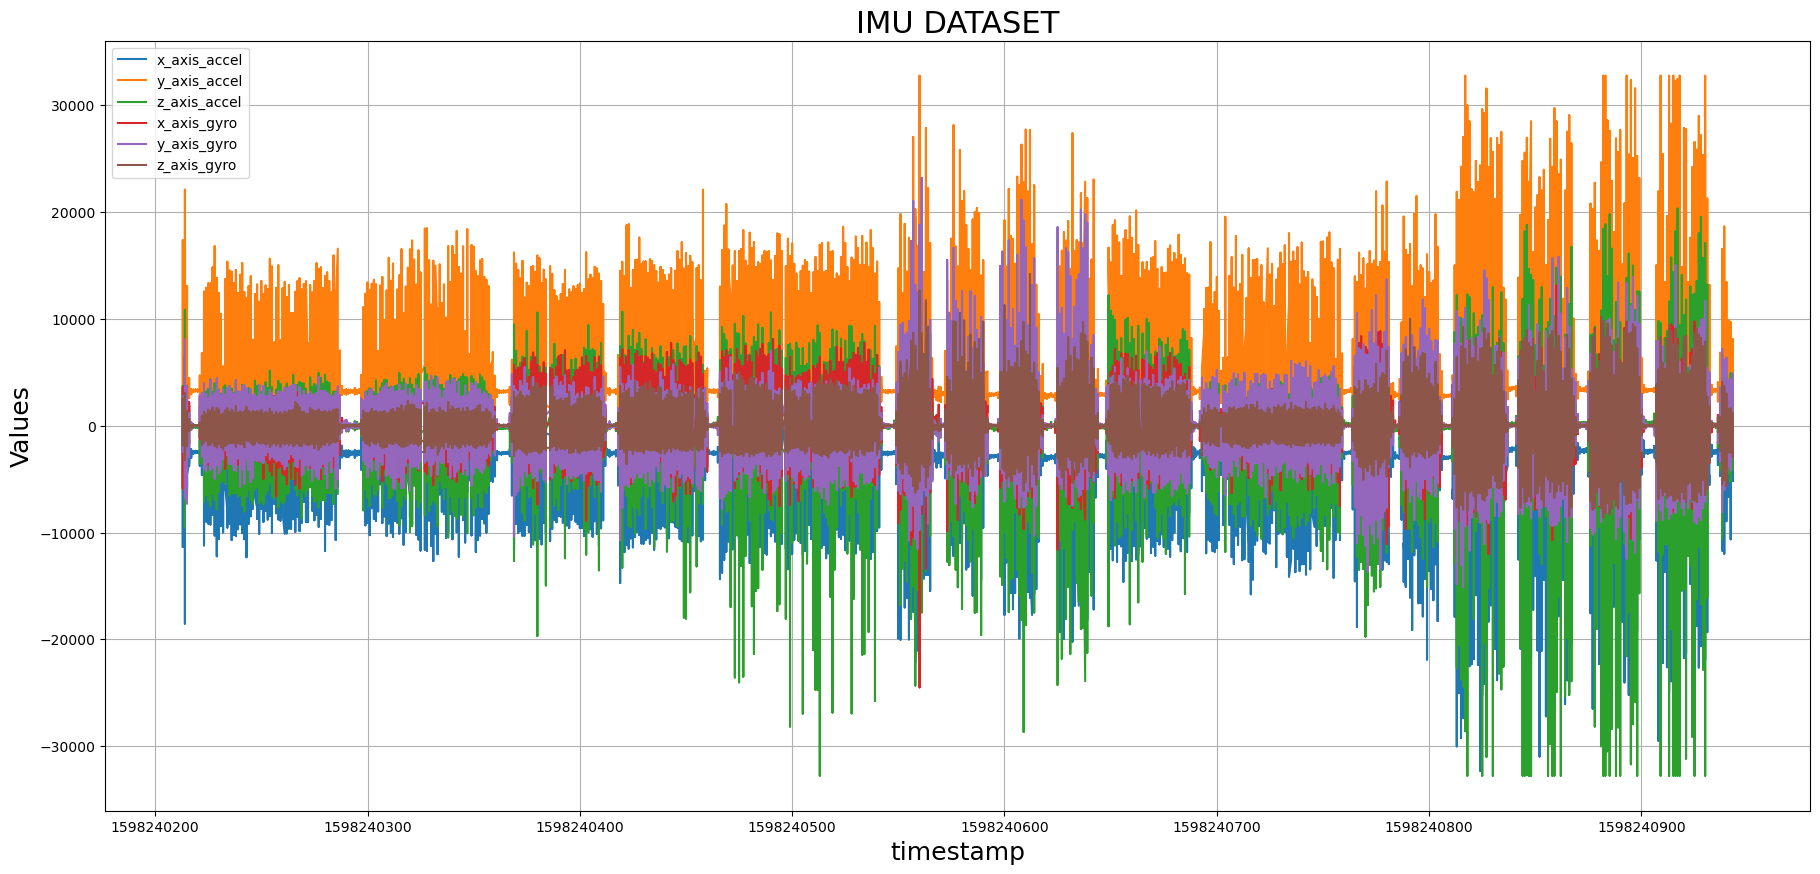

In [362]:
# Cal the plot_dataframe function passing it our dataframes timestamp column for the X axis and every other column for our y values

imu_data_raw["time (seconds)"] = convert_time_series(imu_data_raw["timestamp"])

plot_dataframe(imu_data_raw["timestamp"],  imu_data_raw.drop(["timestamp", "time (seconds)"], axis=1), "IMU DATASET")

By the looks of it, our IMU dataset looks pretty straight forward:
- There are no null values
- We were able to correctly name the columns
- There are 71,000 samples of data
- All data values are integers
- The timestamp are unix time stamps
- We have created a new column value "time (seconds)" <br>
that tracks the time from the start of the data to <br>
any given point in seconds
<br>

One thing that stands out when visualizing this dataset is the start and end points of the data don't really match any other sections of the set, depending on <br>
what our activity data looks like, we may have to slice out these points to align the data more accuratly. Another thing of note is the different sections of<br>
of the dataset. There appears to be 17 different movement sections with 4 or 5 different movement patterns, another thing to look out for when we are aligning <br>
our data.
Let's move onto our activity data set now and see what are working with and what we might have to fix

### Activity Dataset Inpection

In [363]:
check_for_null(activity_data_raw, "ACTIVITY DATA")

ACTIVITY DATA's NULL values 

image has 0 null values
xmin has 0 null values
ymin has 0 null values
xmax has 0 null values
ymax has 0 null values
label has 0 null values


In [364]:
activity_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   34 non-null     object 
 1   xmin    34 non-null     float64
 2   ymin    34 non-null     float64
 3   xmax    34 non-null     float64
 4   ymax    34 non-null     float64
 5   label   34 non-null     object 
dtypes: float64(4), object(2)
memory usage: 1.7+ KB


In [365]:
activity_data_raw.head()

,image,xmin,ymin,xmax,ymax,label
0,a3.mp4#t=0.0,868.943127,417.331032,919.139168,557.535077,Walking
1,a3.mp4#t=66.2,854.251592,330.392238,926.484935,564.882015,Standing
2,a3.mp4#t=75.4,855.475924,324.882034,929.545709,561.820810,Walking
3,a3.mp4#t=139.333333,849.966598,321.208565,928.933599,563.045281,Standing
4,a3.mp4#t=146.733333,855.475924,327.331004,935.667145,553.249400,Jogging


Similiarly like with the IMU dataset our Activity Dataset has a "not so straight forward" timestamp series, this is under the column named "image" and appears to <br>
be in the form of a string. We do need the time values from this set so that we can align our datasets later on. Fortunately it should be easy to create a clean<br>
set of data for time series from these values. Moving onto the other non-number series of data in the dataset, the labels. These will be our targets/labels/y-series<br>
that we will use to train our classifiers on later on, the rest of the data we don't need for this project. Let's fix our time series and then figure out what to plot.

In [366]:
# Create a list to append our new time values too
time = []

# Iterate through every row of the "image" column
for row in activity_data_raw.image:
    # Split the row on the "=" and append only the second element as this is float
    # value that appears after the equals and not the a3.mp4# that appears before.
    time.append(float(row.split("=")[1]))

# Add the new series to our dataframe
activity_data_raw["time"] = time
activity_data_raw.head()

,image,xmin,ymin,xmax,ymax,label,time
0,a3.mp4#t=0.0,868.943127,417.331032,919.139168,557.535077,Walking,0.000000
1,a3.mp4#t=66.2,854.251592,330.392238,926.484935,564.882015,Standing,66.200000
2,a3.mp4#t=75.4,855.475924,324.882034,929.545709,561.820810,Walking,75.400000
3,a3.mp4#t=139.333333,849.966598,321.208565,928.933599,563.045281,Standing,139.333333
4,a3.mp4#t=146.733333,855.475924,327.331004,935.667145,553.249400,Jogging,146.733333


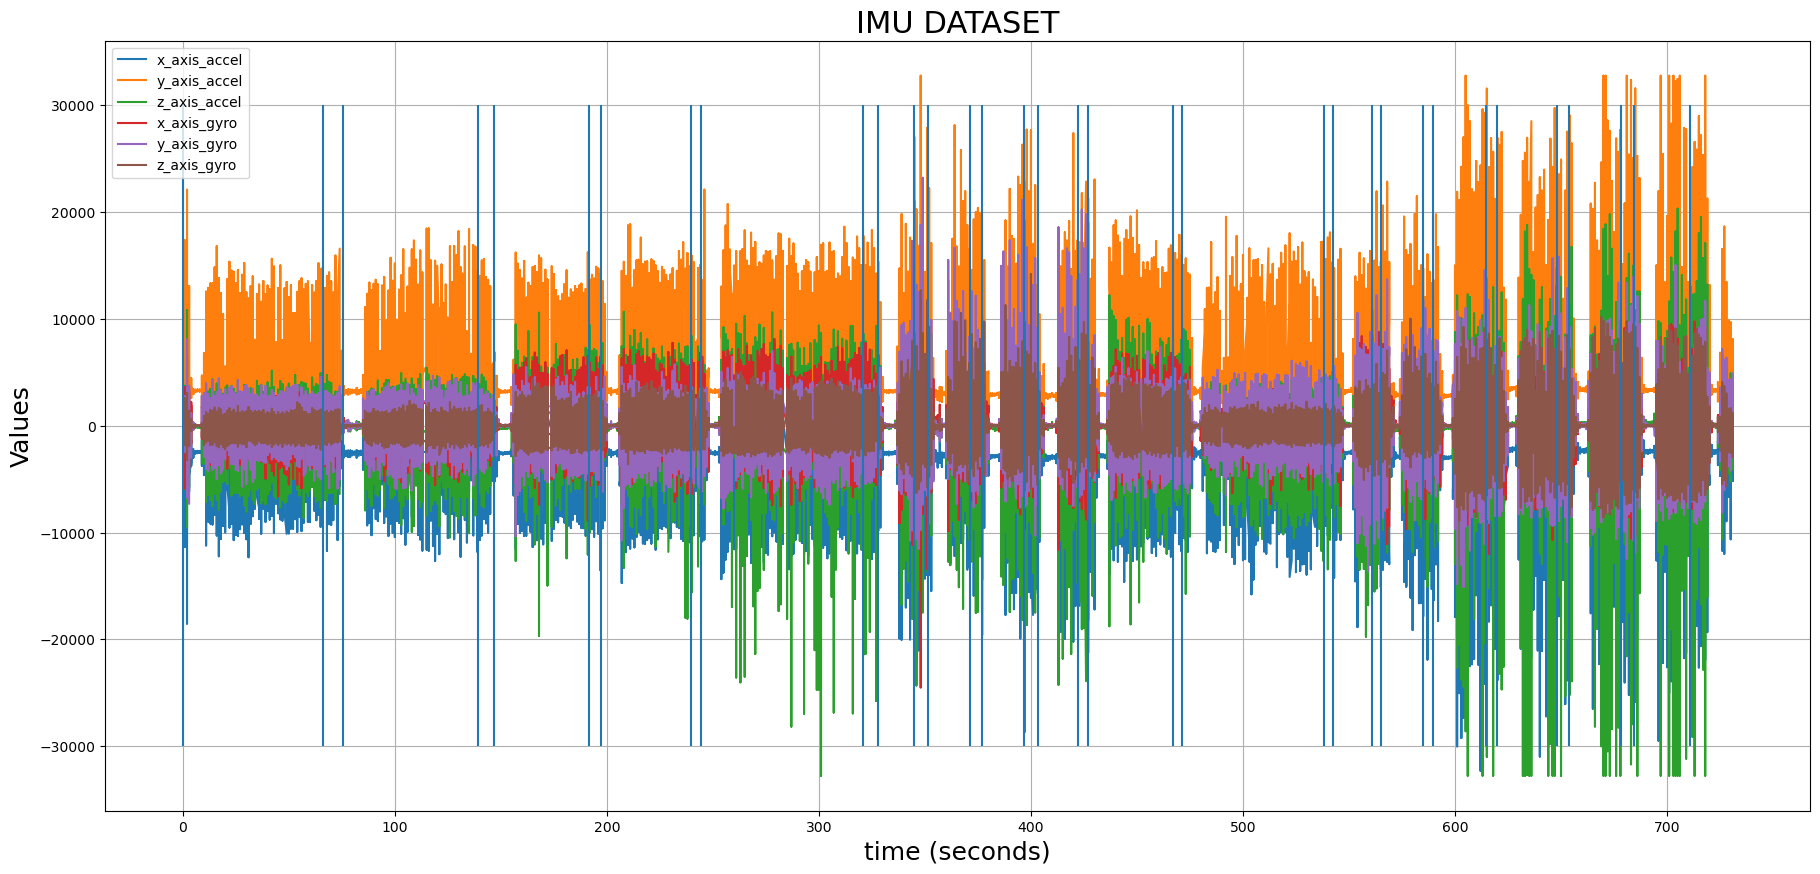

In [367]:
# Re-plot our IMU data and overlay the time points inthe activity dataset where the labels change
plot_dataframe(imu_data_raw["time (seconds)"],  imu_data_raw.drop(["timestamp", "time (seconds)"], axis=1), "IMU DATASET")

# Add vertical lines for every activity change
plt.vlines(activity_data_raw["time"], -30000,30000)
plt.show()

In [368]:
# Printing the first value of our labels series
activity_data_raw.label[0]

'Walking'

Ok, so from the above plot we can see that our data is not aligned, judging by the small gaps between the vertical lines, and the fact that the first activity label is walking,<br>
the small blip of imu data at the start needs to be removed and we need our imu dataset to start a little later where the first section of consistancy begins. This should <br>
solve the alignment problem of our datasets, we also need to remove the last section of the imu data after the last section of consistancy. To find what values we need to slice <br>
out, we can use some trial and error passing in sliced sections of our imu dataset to our plot function and finding the exact values we need. Afterwards we can reassign our data<br>
frame without the uneeded rows of data and then re-adjust the time series again.

## Align and combined the activity and imu datasets using the activity transitions

In [369]:
# Slice up our imu data to remove unwanted start and end data
imu_processed = imu_data_raw.drop(["time (seconds)"], axis=1)[900:70000]

# reset the inde on the dataframe and drop the old index column
imu_processed = imu_processed.reset_index().drop("index", axis=1)
imu_processed.head()

,timestamp,x_axis_accel,y_axis_accel,z_axis_accel,x_axis_gyro,y_axis_gyro,z_axis_gyro
0,1598240222,-2602,2848,-3576,-413,-51,-205
1,1598240222,-2850,2936,-3502,-315,-1,-123
2,1598240222,-3172,2890,-3450,-248,114,-17
3,1598240222,-3340,2772,-3240,-236,273,60
4,1598240222,-3346,2566,-3114,-287,469,83


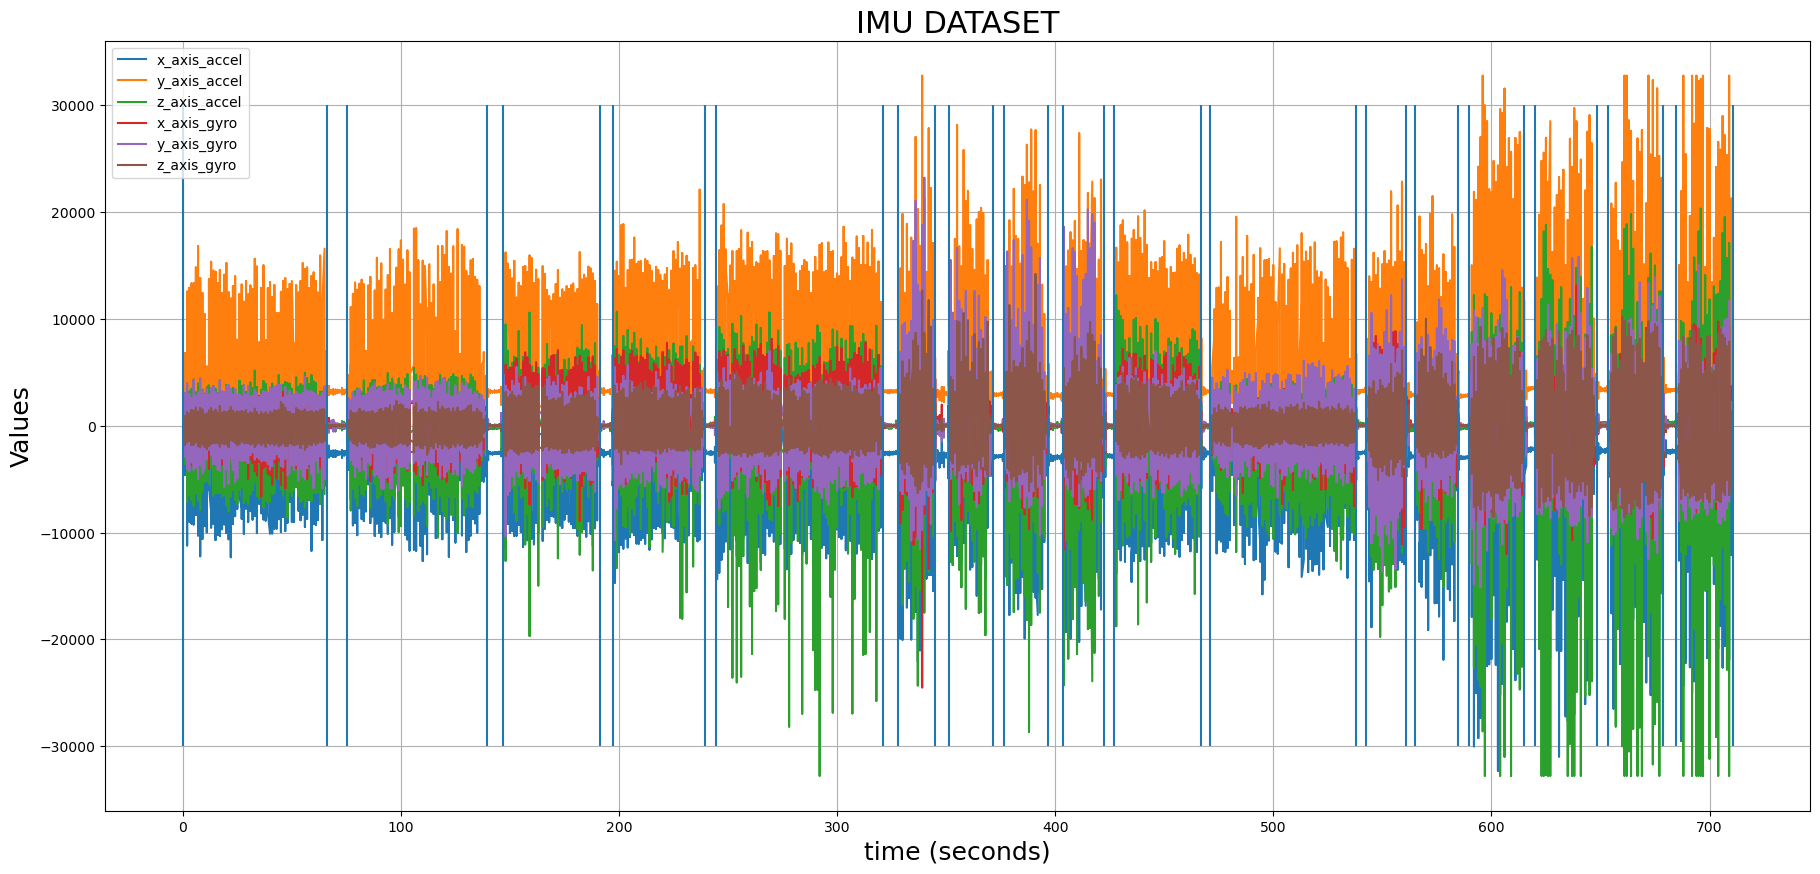

In [370]:
# Re-call the unix timestamp converter to re-adjust the time values
imu_processed["time (seconds)"] = convert_time_series(imu_processed["timestamp"])

plot_dataframe(imu_processed["time (seconds)"],  imu_processed.drop(["timestamp", "time (seconds)"], axis=1), "IMU DATASET")

plt.vlines(activity_data_raw["time"], -30000,30000)
plt.show()

## Process the activity annotation data to assign a target activity to each data point within the IMU dataset.

In [371]:
# Setting an index for the activity label data row
index=1

# Creating a list to hold our activity labels
label=[]

# Iterating through every row of our imu dataset
for row in range(len(imu_processed)):

    # If the time for any given row in our imu data is less than the time in our activity data, we are appending the 
    # label from the activity data to our list of activity labels. Since the activity data's time starts at 0.00, this 
    # will throw our labels off by one row, so we minus 1 when appending to ensure we get the correct label assigned.
    if imu_processed["time (seconds)"][row] <= activity_data_raw.time[index]:
        label.append(activity_data_raw.label[index-1])
    # if the time for a given row from our imu data is greater then the current time in our activity data, we increment
    # the index by one, shifting our activity data to the next row, and continue to append whatever the activity label
    # is for that row to our activity list.
    else: 
        index +=1
        label.append(activity_data_raw.label[index-1])

# Create a new column in our imu dataset with our new labels which will be our targets for training.
imu_processed["label"] = label

# Sanity check to make sure all worked out
# for x in imu_processed["label"]:
#     print(x)
imu_processed.head()

,timestamp,x_axis_accel,y_axis_accel,z_axis_accel,x_axis_gyro,y_axis_gyro,z_axis_gyro,time (seconds),label
0,1598240222,-2602,2848,-3576,-413,-51,-205,1,Walking
1,1598240222,-2850,2936,-3502,-315,-1,-123,1,Walking
2,1598240222,-3172,2890,-3450,-248,114,-17,1,Walking
3,1598240222,-3340,2772,-3240,-236,273,60,1,Walking
4,1598240222,-3346,2566,-3114,-287,469,83,1,Walking


So now we have our labels from our activity dataset appeneded to our imu dataset and everything is sliced up and aligned. We have time counted in seconds instead <br>
of unix timestamps, all we need to do before firing up a our classifiers is to create some features from our data to train the classifiers on. This is what we will <br>
now turn our attention to in the next section.

## Calculate a set of features from the raw sensor data.

### Feature functions

#### Mean

In [372]:
# Function to calculate the mean for a series.

def calculate_mean(time_series, target_series, time_steps):
    """
    Calculates the mean of a pandas data series for a given period of time

    Params:
    time_series - A pandas series used to keep track of time for values in the target_series
    target_series - A pandas series of data to calculate the mean on
    time_steps - The timeframe (i.e number of seconds) to calculate the mean over
    Returns:
    mean - A list of averages from the target_series calculated over the given time_steps. 
    """
    # length of time to calculate mean over, ie 1 = 1 second, 5 = 5 seconds, etc
    seconds = time_steps
    # the cumulative total of values
    cumsum = 0
    # the number of entries that have been added together
    divisor = 0
    # list to hold the averages to be returned
    mean = []

    # iterate through every row of the dataframe
    for row in range(len(time_series)):

        # if the time in the dataframe is less then the desired time steps ie. if the current
        # row's time in seconds is less then the desired total time to calculate the mean over
        if time_series[row] <= seconds:
            # add the rows data to the sum
            cumsum += target_series[row]
            # increment the divors by 1
            divisor += 1
        # otherwise if the above is not the case, then the next row of data's time has gone up
        # i.e we have reached the end of the calculatable period
        else:
            # safety net for divide by zero case
            if divisor != 0:
                # divide the total accumulated sum by the amount of entries, and append it to the list
                mean.append(round(cumsum/divisor, 6))
            else:
                # append 0 if there were no values, (we can deal with zero values later)
                mean.append(0)
            # Reset all of the variables for the next time step
            divisor = 0
            cumsum = 0
            cumsum += target_series[row]
            seconds += time_steps

    return mean

#### Max value

In [373]:
# Function to calculate the max values

def calculate_max(time_series, target_series, time_steps):
    """
    Calculates the max value of each step in a given time period in a pandas series

    Params:
    time_series - A pandas series used to keep track of time for values in the target_series
    target_series - A pandas series of data to calculate the max on
    time_steps - The timeframe (i.e number of seconds) to calculate the max over
    Returns:
    max_ls - A list of max values from the target_series calculated over the given time_steps. 
    
    """
    # length of time to calculate mean over, ie 1 = 1 second, 5 = 5 seconds, etc
    seconds = time_steps
    # Default value for max
    max = 0
    # list to hold the max values to be returned
    max_ls = []

    # iterate through every row in the dataseries
    for row in range(len(imu_processed["time (seconds)"])):

        # check for negative values and change them to positive for fair comparison
        if target_series[row] < 0:
            target = target_series[row] * -1
        else:
            target = target_series[row]

        # for every value in the current time step, check if the value of max is 
        # greater then the current row of data, if it isnt, replace it with the
        # current row of data for the current time step
        if time_series[row] <= seconds:
            if target > max:
                max = target
        else:
            # if the time_series is greater then the current time step, than append
            # the max value to the list, and increment the values for the next time step
            max_ls.append(round(max, 6))
            seconds += time_steps
            max = target

    return max_ls

#### Signal Magnitude Area

In [374]:
# Function to calculate the signal magnitude area

def calculate_signal_magnitude_area(time_series, x, y, z, time_step):
    """
    Calculates the signal magnitude area of a given x, y and z pandas series for a
    given time period 

    Params:
    time_series - A pandas series used to keep track of time for values in the target_series
    x - An x series of data to be used for hte signal magnitude 
    y - An y series of data to be used for the signal magnitude 
    z - An z series of data to be used for the signal magnitude 
    time_steps - The timeframe (i.e number of seconds) to calculate the signal magnitude over
    Returns:
    sma - A list of signal magnitude values from the x, y, z, target series calculated over the given time_steps. 
    """
    # length of time to calculate mean over, ie 1 = 1 second, 5 = 5 seconds, etc
    seconds = time_step
    # the cumulative total of values
    cumsum = 0
    # the number of entries that have been added together
    divisor = 0
    # a list to hold all of the signal magnitude features
    sma = []

    # Iterates through all rows of the time series
    for i in range(len(time_series)):

        # if the time in the dataframe is less then the desired time steps ie. if the current
        # row's time in seconds is less then the desired total time to calculate the value over
        if time_series[i] <= seconds:
            # add the values of all three series to the cumulative total
            cumsum += x[i] + y[i] + z[i]
            # Increment the divisor by 1
            divisor += 1
        else:
            # if the divisor isnt 0
            if divisor != 0:
                # multiply negative values by -1 to get the absolute value
                if cumsum < 0:
                    cumsum = cumsum * -1
                # divide the absolute value by the number of samples and append result to the list
                sma.append(round(cumsum/divisor, 6))
            else:
                # append 0 if the divisor was 0, ie no samples over the time period
                sma.append(0)
            # reset all the values for the time step
            cumsum = 0
            cumsum += x[i] + y[i] + z[i]
            seconds += time_step

    return sma

#### Average Intensity

In [375]:
def calculate_average_intensity(time_series, x, y, z, time_step):
    """
    Calculates the average intensity of a given x, y and z pandas series for a
    given time period 

    Params:
    time_series - A pandas series used to keep track of time for values in the target_series
    x - An x series of data to be used for the average intensity
    y - An y series of data to be used for the average intensity 
    z - An z series of data to be used for the average intensity
    time_steps - The timeframe (i.e number of seconds) to calculate the average intensity over
    Returns:
    ai - A list of average intensity values from the x, y, z, target series calculated over the given time_steps. 
    """
    seconds = time_step
    xsum, ysum, zsum = 0, 0, 0
    # ysum = 0
    # zsum = 0
    divisor = 0
    # list to hold the average intensity values
    ai = []
    for i in range(len(time_series)):

        # if the time in the dataframe is less then the desired time steps ie. if the current
        # row's time in seconds is less then the desired total time to calculate the value over
        if time_series[i] <= seconds:
            
            xsum += x[i]
            ysum += y[i]
            zsum += z[i]
            # Increment the divisor by 1
            divisor += 1
        else:
            # if the divisor isnt 0, square the values
            if divisor != 0:
                xsum = xsum**2
                ysum = ysum**2
                zsum = zsum**2

                # TAKE THE SQUARE ROOOOT
                sqrt = math.sqrt(xsum+ysum+zsum)

                # divide the value by the amount of samples and add it to the list
                ai.append(round(sqrt/divisor, 6))
            else:
                # Append 0 if the divisor is 0, i.e there were no samples
                ai.append(0)
            # Reset all the values for the next time_step
            xsum, ysum, zsum = 0, 0, 0
            # xsum = 0
            # ysum = 0
            # zsum = 0
            xsum += x[i]
            ysum += y[i]
            zsum += z[i]
            seconds += time_step
    return ai

#### Acitivity Labels

In [376]:
# Function for activity labels

def assign_labels(time_series, target_series, time_steps):
    """
    
    """
    
    seconds = time_steps

    activity = []
    # Iterate through all rows of the dataframe and assign a target activity label for each time step
    for row in range(len(time_series)):
        # similiar to the features functions above, if the current row of the time series has the same
        # value of time as the time_step, then continue to the next row
        if time_series[row] <= seconds: continue
        # if the value in the time series is now greater then the current time_step, then append the last
        # activity to the list, this will be the label for that time_step
        else:
            # Assign the last label to the list
            activity.append(target_series[row-1])
            seconds += time_steps
    return activity

### Create a new Dataframe made of features

In [591]:
# Create a new dataframe to hold all of our features
imu_features = pd.DataFrame()

# Set a time step to calculate all features over, this is the amount of seconds that each feature should be calculated 
# over, be warned, when increasing this number it doesn't take long for the accuracy of the features to drop 
# dramatically as you are calculating over longer time periods with activity changes.
time_steps = 2

# time series of values
time_series = imu_processed["time (seconds)"]

# Mean features
imu_features["x_accel_mean"] = calculate_mean(time_series, imu_processed["x_axis_accel"], time_steps)
imu_features["y_accel_mean"] = calculate_mean(time_series, imu_processed["y_axis_accel"], time_steps)
imu_features["z_accel_mean"] = calculate_mean(time_series, imu_processed["z_axis_accel"], time_steps)
imu_features["x_gyro_mean"] = calculate_mean(time_series, imu_processed["x_axis_gyro"], time_steps)
imu_features["y_gyro_mean"] = calculate_mean(time_series, imu_processed["y_axis_gyro"], time_steps)
imu_features["z_gyro_mean"] = calculate_mean(time_series, imu_processed["z_axis_gyro"], time_steps)

# max features
imu_features["x_accel_max"] = calculate_max(time_series, imu_processed["x_axis_accel"], time_steps)
imu_features["y_accel_max"] = calculate_max(time_series, imu_processed["y_axis_accel"], time_steps)
imu_features["z_accel_max"] = calculate_max(time_series, imu_processed["z_axis_accel"], time_steps)
imu_features["x_gyro_max"] = calculate_max(time_series, imu_processed["x_axis_gyro"], time_steps)
imu_features["y_gyro_max"] = calculate_max(time_series, imu_processed["y_axis_gyro"], time_steps)
imu_features["z_gyro_max"] = calculate_max(time_series, imu_processed["z_axis_gyro"], time_steps)

# Signal magnitude area
imu_features["sma_accel"] = calculate_signal_magnitude_area(time_series, imu_processed["x_axis_accel"], imu_processed["y_axis_accel"], imu_processed["z_axis_accel"], time_steps)
imu_features["sma_gyro"] = calculate_signal_magnitude_area(time_series, imu_processed["x_axis_gyro"], imu_processed["y_axis_gyro"], imu_processed["z_axis_gyro"], time_steps)

# average intensity
imu_features["ai_accel"] = calculate_average_intensity(time_series, imu_processed["x_axis_accel"], imu_processed["y_axis_accel"], imu_processed["z_axis_accel"], time_steps)
imu_features["ai_gyro"] = calculate_average_intensity(time_series, imu_processed["x_axis_gyro"], imu_processed["y_axis_gyro"], imu_processed["z_axis_gyro"], time_steps)

# Label feature
imu_features["target"] = assign_labels(time_series, imu_processed["label"], time_steps)

# # Finally add time in seconds to our new dataframe
time = []
steps = 1
# iterate through all row of activites and append a value of time
for row in range(len(imu_features)):
    time.append(steps)
    steps += 1

# add the list to the features dataframe 
imu_features["time"] = time


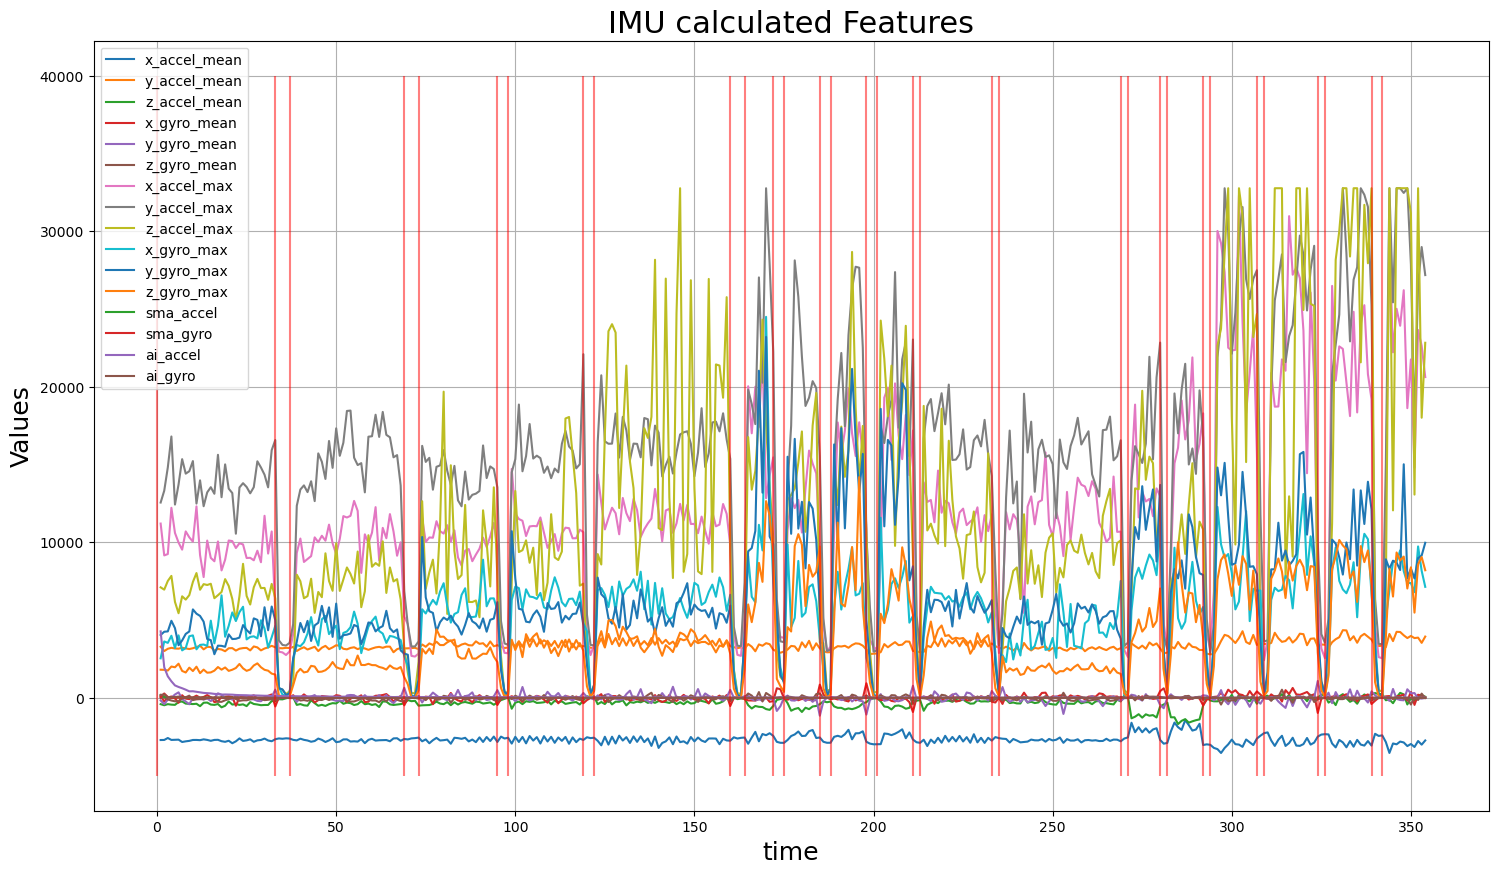

In [592]:
# Since the time steps can change depending on if we want 1, 2, 3, etc second itervals to calculate
# our features over, we have to make sure the activity transitions move with the time steps, below
# is a loop that creates a list of activity transitions depending on the value in the data series
activity_markers = [0]
# Set a variable to keep track of the current activity we are up to
current_label = imu_features["target"][0]
# iterate through all rows of the target labels, ie "walking", "jogging", etc
for row in range(len(imu_features["target"])):
    # if the current activity isnt the same as the target row, append the value to the list and 
    
    if current_label != imu_features["target"][row]:
        activity_markers.append(row)
        # change the current activity to the freshly added value to our list
        current_label = imu_features["target"][row]

# plot the new dataframe with the calculated features and add the vertical lines from the activity series to check it lines up
plot_dataframe(imu_features["time"], imu_features.drop(["target", "time"], axis=1), "IMU calculated Features")

# Plot the vertical lines associated with our activity transitions
plt.vlines(activity_markers, -5000,40000, color="r", alpha=0.5)
plt.show()

Ok so from the above plot we can now see that we were successfully able to transform our data from raw values into a set of features to be used <br>
for classfication. We chose to use the mean, max, signal magnitude, and average intensity values only for each axis. The thought process behind <br>
leaving the minimum out of the set was alot of the data does seem to have similiar minimum values, whereas with the maximum, each activity gives <br>
a very unique max intensity, therefore it was concluded that minimum might not play a big factor in the classification process and was left on the <br>
table. 



## Apply a machine learning workflow, hyper-parameter optimisation, and Classifier visualisation

Now that we have all of our data processed, features assigned, datasets aligned into one, we are finally ready for classification. But before we <br>
start training algorithms, we must first transform our labels to a number system for the classifier to use, split up our data in to test and training <br>
sets as well as scale our values.

In [593]:
# Assign our target values to a new variable
labels = imu_features.target

# Create a label encoder object to encode our string values into integers
lb = LabelEncoder()
# Fit the encoder
labels = lb.fit_transform(labels)

# Sanity check the labels
# lb.classes_
# ceck it worked
# labels

In [594]:
# Create our test train splits

X_train, X_test, y_train, y_test = train_test_split(imu_features.drop(["time", "target"],axis=1), labels, test_size=0.3, random_state=42)

# Convert the x values from dataframes to numpy arrays
X_train = X_train.values
X_test = X_test.values
# X_train

In [595]:
# Scale our data for classification use 
# I DONT KNOW IF THIS WORKED?

# scaler = StandardScaler()
# scaler.fit(X_train)
# scaler.fit(X_test)



In [596]:
def classifiers_metrics(classifier, predict_set, test_set, name):
    """
    
    """
    print(f"The {name}'s Performance metrics and visualisations:\n")
    print(f"Accuracy score:\t\t{accuracy_score(test_set, predict_set)}\n")
   
    # Displaying the precision, recall and f1 score of our test data
    
    print(f"Precision score: \t{precision_score(test_set, predict_set, average='macro', zero_division=False)}")
    print(f"Recall score: \t\t{recall_score(test_set, predict_set, average='macro')}")
    print(f"F1 score: \t\t{f1_score(test_set, predict_set, average='macro')}\n") 

    fig, ax = plt.subplots()

    ConfusionMatrixDisplay.from_predictions(test_set, predict_set, display_labels=lb.classes_, ax=ax)
    ax.set_title(f"{name}'s confusion Matrix")
    
    plt.show()
    

In [615]:
# Training a random forest classifier with hyperparamters of 100 instances of the decision tree and a max depth of 6
rnd = RandomForestClassifier(n_estimators=200, max_leaf_nodes=8, n_jobs=-1)
rnd_clf = rnd.fit(X_train, y_train)

y_pred = rnd.predict(X_test)




In [616]:
ada = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=500,
    algorithm="SAMME.R", learning_rate=0.5)
ada_clf = ada.fit(X_train, y_train)

y_pred = ada.predict(X_test)


In [599]:
for name, score in zip(imu_features.columns.drop(["target", "time"]), rnd.feature_importances_):
    print(name, score)

x_accel_mean 0.02307485912900666
y_accel_mean 0.043754561298479475
z_accel_mean 0.08021004336501592
x_gyro_mean 0.014217147464477036
y_gyro_mean 0.0018288852154516894
z_gyro_mean 0.003162172765851303
x_accel_max 0.08773196623045096
y_accel_max 0.07920913023371663
z_accel_max 0.07031176177460492
x_gyro_max 0.08462835468707751
y_gyro_max 0.1379519958531915
z_gyro_max 0.254613370271169
sma_accel 0.023555210998153716
sma_gyro 0.0069323295104255205
ai_accel 0.07637663342269282
ai_gyro 0.012441577780235349


In [607]:
# Creating a method to sort through all of our features and pick the best ones to use

def feature_selection(classifier, X_value, y_value, f1, f2):
    """
    Takes in an x, y pair of pandas dataset and two integers. It uses the integers as indexes for the X set of data
    to slice and only use the features represented by those indexes. It does this by training a classifier on the
    sliced data and the y values, then claculates the f1 score and returns the model, and the f1 score.
    params: 
    X_value - a pandas dataset of the x values
    y_value - a pandas dataset of the y values
    f1 - an integer to be used for slicing
    f2 - an integer to be used for slicing
    returns:
    f - The f1 score for the trained set of x and y inputs
    clf - The trained classifier fit with the x and y values that we passed in
    """
    
    # Selects which type of classifier to train, potentially could add more in the future such as
    # RandomForest, SVC, adabooooost, but we'll save that for assignment 3 for the moment
    if classifier == "sgd":
        clf = SGDClassifier(random_state=42)
    elif classifier == "knn":
        # The suggested rule of thumb for the amount of neighbours for the knn classifier is 
        # the sqrt(K)/2 where K is the length of your training dataset.
        neighbours = round(math.sqrt(len(X_train))/2)
        clf = KNeighborsClassifier(n_neighbors=neighbours)
    

    # Fit our classifier with our two chosen features 
    clf.fit(X_train[:, [f1,f2]], y_train)

    # Calculate the predictions our model makes on n number of folds (5 for us here)
    y_train_pred = cross_val_predict(clf, X_value[:, [f1,f2]], y_value, cv=5)

    # Get a hold of the f1_score for comparison 
    f_score = f1_score(y_train, y_train_pred, average="macro")
    
    return f_score, clf
    
    # print(type(f1))    

In [610]:
# Set the variables we will need to distinguish which features are the best for modeling 
best_f1 = 0
best_f2 = 0
best_score = 0

# Choose which classifier you want to use, either "sgd" or "knn", for the scope of the assignment 
# this was mostly a feature used in testing and a little comparison to see how the models competed
# against one another.... for science of course!
classifier = "knn"

# A nested for loop to interate through all combinations of feautures in our data set 
# it sends each combination to a function which will determine the most accurate 
# selection of two features to use in our model
for feature_1 in range(16):
    for feature_2 in range(16):
        # if the features are the same as one another, skip them.
        if feature_1 == feature_2:
            continue

        # Call our selection function passing in the training sets and feautures from the
        # loop, and assign it's outputs accordingly 
        returned_score, clf = feature_selection(classifier, X_train, y_train, feature_1, feature_2)

        # Control structure for determining the highest f1 scores and best trained model
        # if the score return is > the current best score, then rewrite the variables to
        # the new values
        if float(returned_score) > best_score:
            best_score = returned_score
            best_f1 = feature_1
            best_f2 = feature_2
            classifier_of_choice = clf

            # Print out a viualization of each combination that was better than the last
            print(f"First Feature: {best_f1}\tSecond Feature: {best_f2}\tF1 score: {best_score}") 


First Feature: 0	Second Feature: 1	F1 score: 0.6355891141744344
First Feature: 0	Second Feature: 2	F1 score: 0.7043286118043068
First Feature: 0	Second Feature: 11	F1 score: 0.8219725058155476
First Feature: 2	Second Feature: 11	F1 score: 0.8275003118946781
First Feature: 6	Second Feature: 11	F1 score: 0.8516862567800262


The KNNeighboursClassifier's Performance metrics and visualisations:

Accuracy score:		0.9065420560747663

Precision score: 	0.915343137254902
Recall score: 		0.8910706363858646
F1 score: 		0.901056537347664



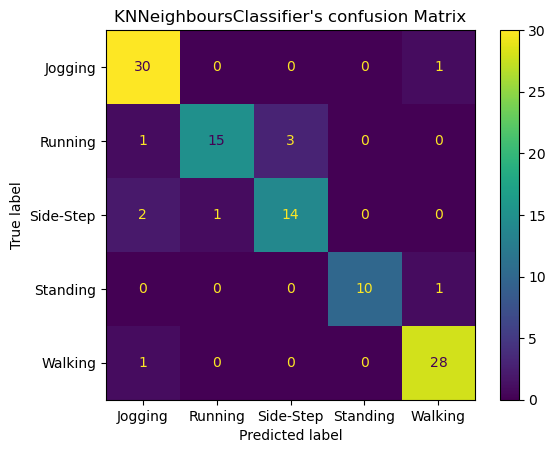

In [613]:


y_pred = classifier_of_choice.predict(X_test[:,[best_f1, best_f2]])



The RandomForestClassifier's Performance metrics and visualisations:

Accuracy score:		0.897196261682243

Precision score: 	0.9354112554112554
Recall score: 		0.8680696286050704
F1 score: 		0.8927517176074051



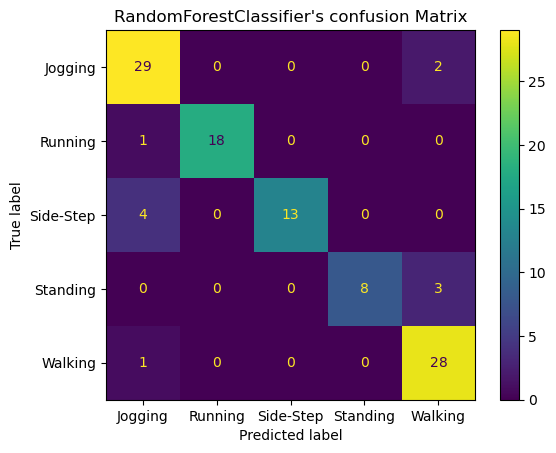

In [617]:
classifiers_metrics(rnd_clf, y_pred, y_test, "RandomForestClassifier")

The AdaBoostClassifier's Performance metrics and visualisations:

Accuracy score:		0.897196261682243

Precision score: 	0.9354112554112554
Recall score: 		0.8680696286050704
F1 score: 		0.8927517176074051



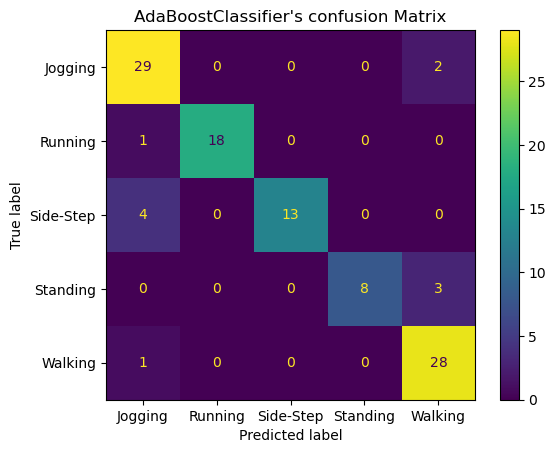

In [618]:
classifiers_metrics(ada_clf, y_pred, y_test, "AdaBoostClassifier")

The KNNeighboursClassifier's Performance metrics and visualisations:

Accuracy score:		0.897196261682243

Precision score: 	0.9354112554112554
Recall score: 		0.8680696286050704
F1 score: 		0.8927517176074051



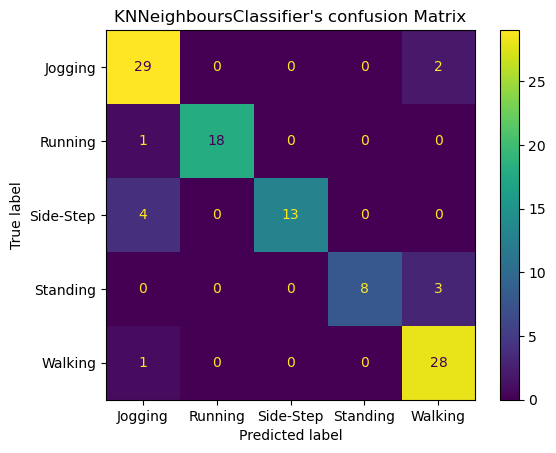

In [619]:
classifiers_metrics(classifier_of_choice, y_pred, y_test, "KNNeighboursClassifier")

The VotingClassifier's Performance metrics and visualisations:

Accuracy score:		0.9345794392523364

Precision score: 	0.9577205882352942
Recall score: 		0.9126027073894847
F1 score: 		0.9311682079305029



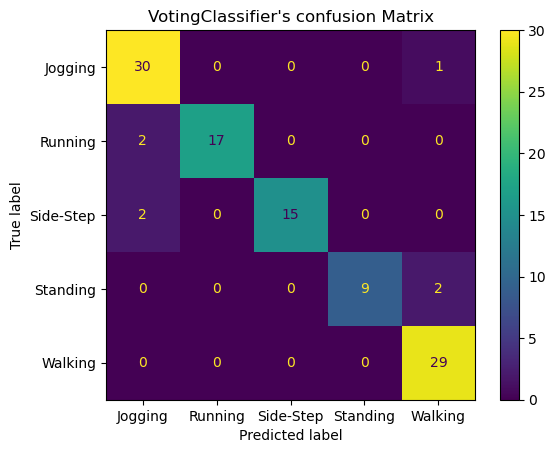

In [620]:
voting = VotingClassifier(estimators = [("rnd", rnd_clf), ("ada", ada_clf), ("knn", classifier_of_choice)], voting="hard")

vote_clf = voting.fit(X_train, y_train)

y_pred = voting.predict(X_test)

classifiers_metrics(vote_clf, y_pred, y_test, "VotingClassifier")

## Perform hyper-parameter optimization on at least one parameter for each algorithm.

## Create some visualizations and report on the model that your machine learning approaches have learned from the data.